In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from shapely.geometry import Point, box
import os

In [2]:
# data_nyc\zones.geojson

zone = gpd.read_file('../data_nyc/zones.geojson')
zone = zone.reset_index(drop=True)
zone.head()

,ZONEDIST,date,time,geometry
0,['R3A' 'PARK'],2024-01-01,0:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
1,['R3A' 'PARK'],2024-01-01,1:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
2,['R3A' 'PARK'],2024-01-01,2:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
3,['R3A' 'PARK'],2024-01-01,3:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
4,['R3A' 'PARK'],2024-01-01,4:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."


In [3]:
minx, miny, maxx, maxy = zone.total_bounds
bbox = box(minx, miny, maxx, maxy)

In [4]:
temp = zone.copy()
temp.head()

# save temp
# temp.to_file('../data_nyc/temp.geojson', driver='GeoJSON')

,ZONEDIST,date,time,geometry
0,['R3A' 'PARK'],2024-01-01,0:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
1,['R3A' 'PARK'],2024-01-01,1:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
2,['R3A' 'PARK'],2024-01-01,2:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
3,['R3A' 'PARK'],2024-01-01,3:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
4,['R3A' 'PARK'],2024-01-01,4:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."


In [5]:
temp.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# co
# data\co_2024.csv

co = pd.read_csv('../data/co_2024.csv', low_memory=False)

In [7]:
co.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Date Local',
       'Time Local', 'Date GMT', 'Time GMT', 'Sample Measurement',
       'Units of Measure', 'MDL', 'Uncertainty', 'Qualifier', 'Method Type',
       'Method Code', 'Method Name', 'State Name', 'County Name',
       'Date of Last Change'],
      dtype='object')

In [8]:
# 'State Code', 'County Code', 'Site Num', 'Parameter Code', 'Latitude', 'Longitude', 'Datum', 'Date Local',
# 'Time Local', 'Sample Measurement', 'Units of Measure', 'Uncertainty', 'State Name', 'County Name'

params = ['State Code', 'County Code', 'Site Num', 'Parameter Code', 'Latitude', 'Longitude', 'Datum', 'Date Local','Time Local', 'Sample Measurement', 'Units of Measure', 'Uncertainty', 'State Name', 'County Name']
co = co[params]

In [9]:
co_gdf = gpd.GeoDataFrame(
    co,
    geometry=[Point(xy) for xy in zip(co['Longitude'], co['Latitude'])],
    crs='EPSG:4326'
)
co_gdf = co_gdf.to_crs('EPSG:2263')
co_gdf = co_gdf[co_gdf.geometry.within(bbox)]

In [10]:
co_gdf.rename(columns={'Date Local': 'date', 'Time Local': 'time', 'Sample Measurement': 'co measurement', 'Units of Measure': 'co unit'}, inplace=True)
co_temp = co_gdf.copy()
co_temp = co_temp[['date', 'time', 'co measurement', 'co unit', 'geometry']]
co_temp.head()

,date,time,co measurement,co unit,geometry
590700,2024-01-01,00:00,0.3,Parts per million,POINT (993605.973 250250.739)
590701,2024-01-01,01:00,0.3,Parts per million,POINT (993605.973 250250.739)
590702,2024-01-01,02:00,0.3,Parts per million,POINT (993605.973 250250.739)
590703,2024-01-01,05:00,0.3,Parts per million,POINT (993605.973 250250.739)
590704,2024-01-01,06:00,0.3,Parts per million,POINT (993605.973 250250.739)


In [11]:
temp['date'] = pd.to_datetime(temp['date']).dt.date
co_temp['date'] = pd.to_datetime(co_temp['date']).dt.date

temp   ['time'] = pd.to_datetime(temp['time'], format='%H:%M').dt.strftime('%H:%M')
co_temp['time'] = pd.to_datetime(co_temp['time'], format='%H:%M').dt.strftime('%H:%M')


all_results = []

# loop over dates, '2024-01-01', ..., '2024-06-30'
for current_date in pd.date_range('2024-01-01','2024-06-30',freq='D'):
    d = current_date.date()             
    temp_d = temp[temp['date']==d]
    if temp_d.empty: 
        continue
    
    # loop over hours, '00', '01', ..., '23'
    for hour in range(24):
        time_label = f"{hour:02d}:00" 
        temp_h = temp_d[temp_d['time']==time_label]
        co_h   = co_temp[
            (co_temp['date']==d) & 
            (co_temp['time']==time_label)
        ]
        if temp_h.empty or co_h.empty:
            continue

        joined = gpd.sjoin(
            temp_h,
            co_h[['geometry','co measurement']],
            how='left',
            predicate='contains'
        ).drop(columns=['index_right'])

        agg = (
            joined
            .groupby(['date','time','geometry'])['co measurement']
            .mean()
            .reset_index()
            
        )
        agg = gpd.GeoDataFrame(agg, geometry='geometry', crs=temp_h.crs)

        res_h = temp_h.merge(
            agg[['date','time','geometry','co measurement']],
            on=['date','time','geometry'],
            how='left'
        )
        all_results.append(res_h)


In [12]:
result = gpd.GeoDataFrame(
    pd.concat(all_results, ignore_index=True),
    geometry='geometry',
    crs=temp.crs
)
result

,ZONEDIST,date,time,geometry,co measurement
0,['R3A' 'PARK'],2024-01-01,00:00,"POLYGON ((913013.301 118296.425, 916294.141 11...",NaN
1,['R3A' 'R3-2' 'R3X' 'R1-2' 'PARK'],2024-01-01,00:00,"POLYGON ((916294.141 118296.425, 919574.981 11...",NaN
2,['R1-2' 'R3X' 'R1-1'],2024-01-01,00:00,"POLYGON ((919574.981 118296.425, 922855.821 11...",NaN
3,[ NaN ],2024-01-01,00:00,"POLYGON ((922855.821 118296.425, 926136.661 11...",NaN
4,[ NaN ],2024-01-01,00:00,"POLYGON ((926136.661 118296.425, 929417.501 11...",NaN
...,...,...,...,...,...
9648907,[ NaN ],2024-06-30,23:00,"POLYGON ((1050808.581 269215.065, 1054089.421 ...",NaN
9648908,[ NaN ],2024-06-30,23:00,"POLYGON ((1054089.421 269215.065, 1057370.261 ...",NaN
9648909,[ NaN ],2024-06-30,23:00,"POLYGON ((1057370.261 269215.065, 1060651.101 ...",NaN
9648910,[ NaN ],2024-06-30,23:00,"POLYGON ((1060651.101 269215.065, 1063931.941 ...",NaN


In [13]:
print(result.columns.tolist())

['ZONEDIST', 'date', 'time', 'geometry', 'co measurement']


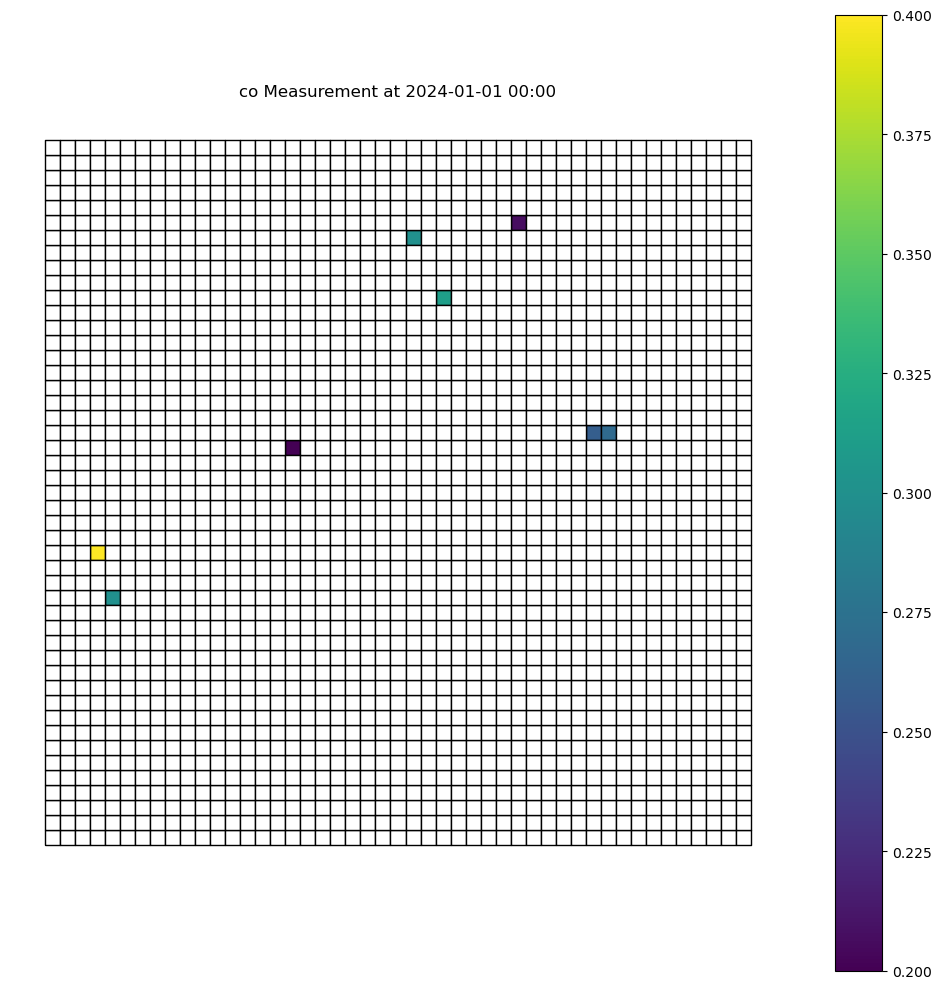

In [14]:
mask = (
    (result['date'] == pd.to_datetime('2024-01-01').date()) &
    (result['time'] == '00:00')
)
slice_0000 = result[mask]

fig, ax = plt.subplots(figsize=(10, 10))
slice_0000.plot(
    column='co measurement',
    legend=True,
    edgecolor='black',
    missing_kwds={'color': 'white'},
    ax=ax
)
ax.set_title('co Measurement at 2024-01-01 00:00')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [15]:
# save result
result['time'] = result['time'].apply(lambda x: x.strftime('%H:%M') if not isinstance(x, str) else x)
result.to_file('../data_nyc/co.geojson', driver='GeoJSON')

In [16]:
result.to_csv('../data_nyc/co.csv', index=False)

In [17]:
result

,ZONEDIST,date,time,geometry,co measurement
0,['R3A' 'PARK'],2024-01-01,00:00,"POLYGON ((913013.301 118296.425, 916294.141 11...",NaN
1,['R3A' 'R3-2' 'R3X' 'R1-2' 'PARK'],2024-01-01,00:00,"POLYGON ((916294.141 118296.425, 919574.981 11...",NaN
2,['R1-2' 'R3X' 'R1-1'],2024-01-01,00:00,"POLYGON ((919574.981 118296.425, 922855.821 11...",NaN
3,[ NaN ],2024-01-01,00:00,"POLYGON ((922855.821 118296.425, 926136.661 11...",NaN
4,[ NaN ],2024-01-01,00:00,"POLYGON ((926136.661 118296.425, 929417.501 11...",NaN
...,...,...,...,...,...
9648907,[ NaN ],2024-06-30,23:00,"POLYGON ((1050808.581 269215.065, 1054089.421 ...",NaN
9648908,[ NaN ],2024-06-30,23:00,"POLYGON ((1054089.421 269215.065, 1057370.261 ...",NaN
9648909,[ NaN ],2024-06-30,23:00,"POLYGON ((1057370.261 269215.065, 1060651.101 ...",NaN
9648910,[ NaN ],2024-06-30,23:00,"POLYGON ((1060651.101 269215.065, 1063931.941 ...",NaN
